In [38]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix

In [9]:
df = pd.read_csv("data/lcs_2021_match_data_OraclesElixir_20210713.csv")
df.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT03/1671978,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2021,Spring,1,2021-01-15 23:10:17,1,11.01,...,129.0,334.0,-603.0,-14.0,2.0,1.0,0.0,1.0,0.0,2.0
1,ESPORTSTMNT03/1671978,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2021,Spring,1,2021-01-15 23:10:17,1,11.01,...,117.0,172.0,-1076.0,-17.0,0.0,3.0,0.0,0.0,1.0,1.0
2,ESPORTSTMNT03/1671978,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2021,Spring,1,2021-01-15 23:10:17,1,11.01,...,121.0,1486.0,476.0,15.0,1.0,2.0,1.0,0.0,1.0,1.0
3,ESPORTSTMNT03/1671978,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2021,Spring,1,2021-01-15 23:10:17,1,11.01,...,120.0,1755.0,1087.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ESPORTSTMNT03/1671978,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2021,Spring,1,2021-01-15 23:10:17,1,11.01,...,19.0,597.0,170.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036 entries, 0 to 3035
Data columns (total 117 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   gameid                    object 
 1   datacompleteness          object 
 2   url                       object 
 3   league                    object 
 4   year                      int64  
 5   split                     object 
 6   playoffs                  int64  
 7   date                      object 
 8   game                      int64  
 9   patch                     float64
 10  playerid                  int64  
 11  side                      object 
 12  position                  object 
 13  player                    object 
 14  team                      object 
 15  champion                  object 
 16  ban1                      object 
 17  ban2                      object 
 18  ban3                      object 
 19  ban4                      object 
 20  ban5                      obj

In [20]:
drop_columns = ["datacompleteness", "url", "year", "split", "date", "patch", "split", "league",
                "playoffs", "side", "position", "playerid", "champion", "player", "gameid",
                "ban1", "ban2", "ban3", "ban4", "ban5"]

data_df = df.drop(columns=drop_columns, axis=1)

data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036 entries, 0 to 3035
Data columns (total 98 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   game                      3036 non-null   int64  
 1   team                      3036 non-null   object 
 2   gamelength                3036 non-null   int64  
 3   result                    3036 non-null   int64  
 4   kills                     3036 non-null   int64  
 5   deaths                    3036 non-null   int64  
 6   assists                   3036 non-null   int64  
 7   teamkills                 3036 non-null   int64  
 8   teamdeaths                3036 non-null   int64  
 9   doublekills               3036 non-null   float64
 10  triplekills               3036 non-null   float64
 11  quadrakills               3036 non-null   float64
 12  pentakills                3036 non-null   float64
 13  firstblood                3036 non-null   float64
 14  firstblo

In [23]:
X = data_df.drop("result", axis=1)
y = data_df["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=57)

ohe_features = ["team"]

pipe = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown="ignore"),
                          ohe_features)], remainder="passthrough")

encoder = pipe.fit(X_train)
X_train, X_test = encoder.transform(X_train), encoder.transform(X_test)

In [32]:
boost_model = XGBClassifier(random_state=57, objective="reg:squarederror", use_label_encoder=False)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.6, 0.7],
    'n_estimators': [10, 20, 30, 40, 50, 100]
}

gridsearch = GridSearchCV(boost_model, param_grid, scoring="accuracy", cv=3, n_jobs=1)
gridsearch.fit(X_train, y_train)

best_parameters = gridsearch.best_params_

print("Best Parameters: ")
print(best_parameters)

Best Parameters: 
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}


In [34]:
train_pred = gridsearch.predict(X_train)
test_pred = gridsearch.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred)

print("Training Scores")
print("Accuracy: ", train_acc)
print("F1: ", train_f1)

test_acc = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)

print("Test Scores")
print("Accuracy: ", test_acc)
print("F1: ", test_f1)

Training Scores
Accuracy:  1.0
F1:  1.0
Test Scores
Accuracy:  0.9868247694334651
F1:  0.9867724867724869


In [37]:
roc_auc_score(y_test, test_pred)

0.9868316900430496

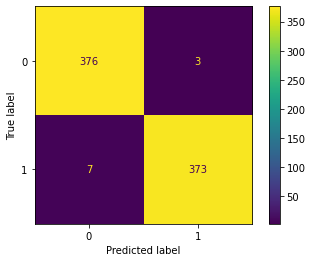

In [39]:
plot_confusion_matrix(gridsearch, X_test, y_test)